In [1]:
import pandas as pd

%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#importing libraries and printing wdir
import os
import pathlib as pth
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt, patches
import numpy as np
import importlib
import ipywidgets as ipw
import scipy.signal as si
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import dblquad
from scipy.optimize import differential_evolution
from scipy import interpolate
import time
from scipy.integrate import solve_ivp
from matplotlib.colors import LogNorm
#from numba import get_num_threads,set_num_threads,config,threading_layer
from numba import jit, config, set_num_threads, get_num_threads,threading_layer


print("Current Working Directory:", os.getcwd())
print("Files in Directory:", os.listdir())  # List all files and folders


# Load the XLS file
file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format

# Display the first few rows
print(df.head())

# Accessing columns
for column in df.columns:
    print(f"Column: {column}")
    print(df[column].head())  # Print first few values in each column

import bimet_morelife_gen3c
importlib.reload(bimet_morelife_gen3c)


nm=1e-9

Current Working Directory: /home/matej/work/proj/morelife/bimet_fit
Files in Directory: ['bimet_morelife_gen3c.py', '.~lock.g3c_input.xlsx#', '.ipynb_checkpoints', 'g3c_input.xlsx', 'work', '__pycache__', 'importg3c.ipynb', 'PSD Analysis (JJ-0218).xlsx']
        GDL       MEM       MID     GDL.1     MEM.1     MID.1
0  4.750779  4.984424  4.517134  4.361371  4.984424  3.582555
1  4.049844  4.672897  2.803738  6.464174  5.373832  3.738318
2  3.971963  3.348910  3.971963  4.750779  4.906542  4.595016
3  4.205607  3.037383  4.127726  3.348910  3.971963  3.660436
4  4.361371  3.115265  3.348910  4.127726  4.672897  3.816199
Column: GDL
0    4.750779
1    4.049844
2    3.971963
3    4.205607
4    4.361371
Name: GDL, dtype: float64
Column: MEM
0    4.984424
1    4.672897
2    3.348910
3    3.037383
4    3.115265
Name: MEM, dtype: float64
Column: MID
0    4.517134
1    2.803738
2    3.971963
3    4.127726
4    3.348910
Name: MID, dtype: float64
Column: GDL.1
0    4.361371
1    6.464174
2    4.

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


vec_l
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09 2.875e-09 3.125e-09 3.375e-09
 3.625e-09 3.875e-09 4.125e-09 4.375e-09 4.625e-09]
vec_c
[1.2500e-10 3.7500e-10 6.2500e-10 8.7500e-10 1.1250e-09 1.3750e-09
 1.6250e-09 1.8750e-09 2.1250e-09 2.3750e-09 2.6250e-09 2.8750e-09
 3.1250e-09 3.3750e-09 3.6250e-09 3.8750e-09 4.1250e-09 4.3750e-09
 4.6250e-09 4.8750e-09 5.1250e-09 5.3750e-09 5.6250e-09 5.8750e-09
 6.1250e-09 6.3750e-09 6.6250e-09 6.8750e-09 7.1250e-09 7.3750e-09
 7.6250e-09 7.8750e-09 8.1250e-09 8.3750e-09 8.6250e-09 8.8750e-09
 9.1250e-09 9.3750e-09 9.6250e-09 9.8750e-09 1.0125e-08 1.0375e-08
 1.0625e-08 1.0875e-08 1.1125e-08 1.1375e-08 1.1625e-08 1.1875e-08
 1.2125e-08 1.2375e-08 1.2625e-08 1.2875e-08 1.3125e-08 1.3375e-08
 1.3625e-08]
starting input data fit
working from dir: /home/matej/work/proj/morelife/bimet_fit
test one simulation run
0	30000.0
1	0.06
2	2.2000000000000003e-05
3	12000.0
4	0.5
5	2.0
6	1.03


In [2]:

file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format
data_array = df.to_numpy()
print(np.shape(data_array))


(4241, 6)


In [3]:
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#hist
#bins_r
nm*df.iloc[:, 0].dropna().to_numpy()*0.5

NameError: name 'bins_r' is not defined

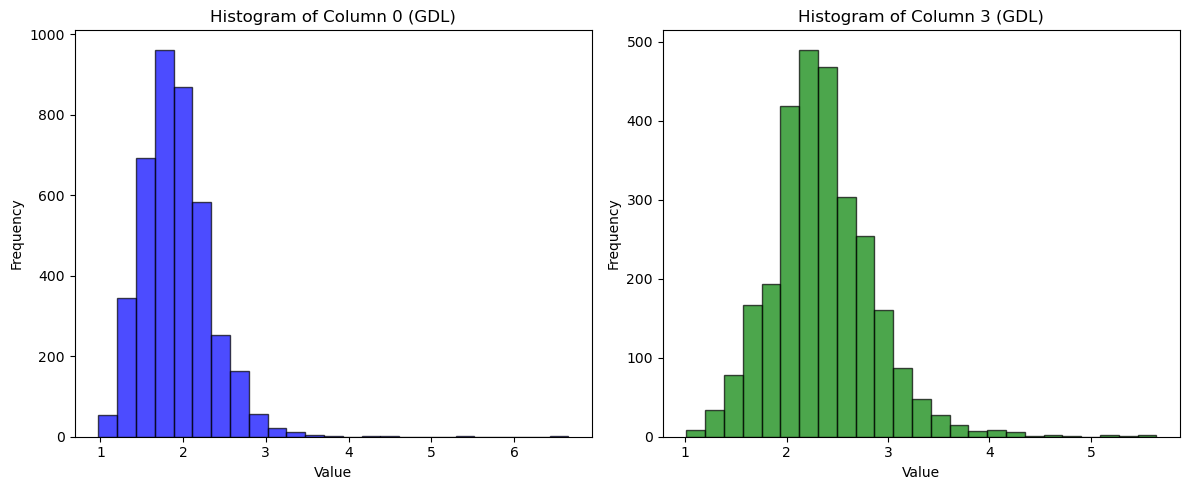

In [4]:
selected_columns = df.iloc[:, [0, 3]]  # Select first and fourth columns

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for Column 0
plt.subplot(1, 2, 1)
plt.hist(selected_columns.iloc[:, 0].dropna()*0.5, bins=25, color='blue', edgecolor='black', alpha=0.7)
#hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#plt.stem(hist[1][:-1],hist[0])
#plt.xlim([0.5*nm,7*nm])
plt.title(f"Histogram of Column 0 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Histogram for Column 3
plt.subplot(1, 2, 2)
plt.hist(selected_columns.iloc[:, 1].dropna()*0.5, bins=25, color='green', edgecolor='black', alpha=0.7)
plt.title(f"Histogram of Column 3 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [5]:
#data succesfully imported
#now describe starting distribution
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
#n=7 starting synthetic ratio.
#end mass ratio. 28/1.8
#translate to atomic ratio
#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON 
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
#finaly normalise to pt data

#n=7 starting synthetic ratio. Fixed in librarz CHECK
#end mass ratio. 28/1.8 TODO CHECK
Pt_Cu_rat=25.8/0.8
print(f"Mass Ratio (Pt:Cu) = {Pt_Cu_rat:.4f}")

#translate to atomic ratio
def mass_to_atomic_ratio(mass_ratio_pt_to_cu):
    # Atomic masses of Pt and Cu
    atomic_mass_pt = 195.08  # g/mol
    atomic_mass_cu = 63.55   # g/mol

    # Convert mass ratio to atomic ratio
    atomic_ratio = mass_ratio_pt_to_cu * (atomic_mass_cu / atomic_mass_pt)
    
    return atomic_ratio

# Example: If mass ratio (Pt:Cu) is 2:1 (meaning 2g Pt for 1g Cu)
#mass_ratio = 2  # Adjust based on your input
atomic_ratio = mass_to_atomic_ratio(Pt_Cu_rat)

print(f"Atomic Ratio (Pt:Cu) = {atomic_ratio:.4f}")

#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=10,MPars=ModPars0, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
#finaly normalise to pt data 
Pt_load=0.15 #mg/cm2

Mass Ratio (Pt:Cu) = 32.2500
Atomic Ratio (Pt:Cu) = 10.5059


10.9575407936796
10.505882202173467


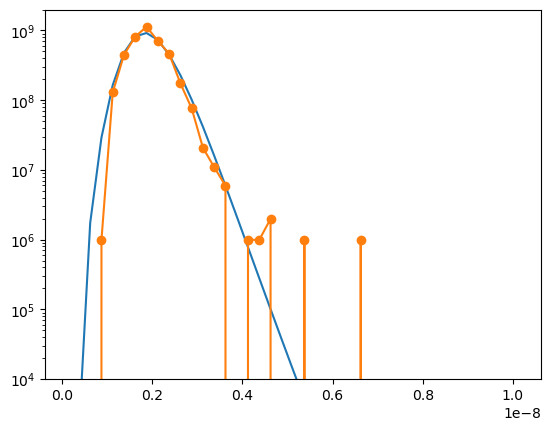

In [41]:
#plot starting dist normed to r, as well as Pt,Cu ratio. Should be more than 3. since some of cu is lost
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
vek_in=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
#dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

#make dr
dc2 = (vec_c[1] - vec_c[0]) * 0.5
#does it have to be that way? would it work with any dr?
dr2 = dc2
#dr vector
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)

nSt = 3
#number of bins
nc = len(vec_c)
nl = len(vec_l)
# total number of variables
nSys = nSt+nc*nl

### set initial distribution
#initial states
X0 = np.zeros(nSys)
# cathode
#fill the bins starting vector
X0[0]=1.0*10**-10
X0[1]=1.0*10**-2
X0[2]=1.0*10**-10
X0[3:]=dist_bins_om.flatten()

#solve a run
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=stop_condition, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=None, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)

#get X from the solution
#X=sol0.y[:,-1]

#transform to r distribution
#res,vec_r=f_cl_to_rl_rc(X,nSt,vec_l,vec_c)
om=bimet_morelife_gen3c.f_X_to_dist(X0,vec_l,vec_c)
r=bimet_morelife_gen3c.f_om_to_r(om)
#norm end r dist
rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

#calculate the price function
#d2_n calculated before, its a hardcoded input for all evolution calls
#price = f_sum_abs(d2_n,rez_norm_r,vec_r)

bins_r=np.insert(vec_r+vec_r[0],0,0)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)

plt.plot(vec_r,rez_norm_r)
plt.plot(vec_r,hist[0],marker="o")
"""
hist = np.histogram(nm*df.iloc[:, 3].dropna().to_numpy()*0.5,bins=bins_r,density=True)
plt.plot(vec_r,rez_norm_r)
plt.plot(vec_r,hist[0],marker="o")
"""
plt.yscale('log')
plt.ylim([1e4,2e9])

X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
#calc pt_cu as well give it half the weight
rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
pt_cu=rez_stats[-2]/rez_stats[-1]

print(pt_cu)
print(atomic_ratio)

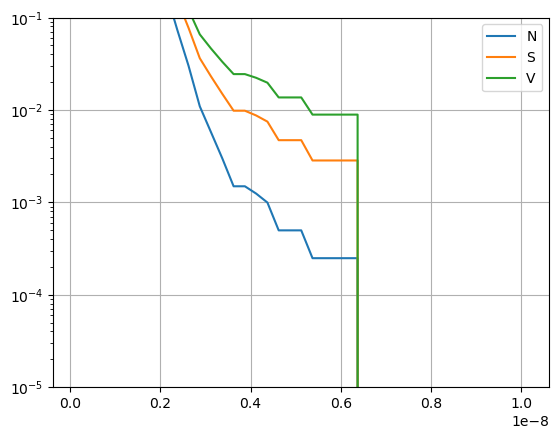

In [59]:

cN=np.cumsum(hist[0])
cN=cN/cN[-1]

cS=np.cumsum(hist[0]*vec_r*vec_r)
cS=cS/cS[-1]

cV=np.cumsum(hist[0]*vec_r*vec_r*vec_r)
cV=cV/cV[-1]

plt.plot(vec_r,1.-cN,label="N")
plt.plot(vec_r,1.-cS,label="S")
plt.plot(vec_r,1.-cV,label="V")

plt.yscale('log')
plt.ylim([1e-5,1e-1])

plt.legend()
plt.grid()
#cumulative surface and volume
#cumulative pt and cu 

In [35]:
#do fast optimisation dif evo price function
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
dc2 = (vec_c[1] - vec_c[0]) * 0.5
dr2 = dc2
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)

def f_price(vek_in):
    dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
    pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

    #dist_bins_om = np.zeros((np.shape(dist_bins_om)))
    #dist_bins_om[5,10]=1e30
    
    dc2 = (vec_c[1] - vec_c[0]) * 0.5
    dr2 = dc2
    vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)

    r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
    rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

    bins_r=np.insert(vec_r+vec_r[0],0,0)
    #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    priceN = bimet_morelife_gen3c.f_sum_abs( hist[0],rez_norm_r,vec_r)
    priceS = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
    priceV = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)
    
    #print(priceN)
    #print(priceS)
    #print(priceV)

    X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
    #calc pt_cu as well give it half the weight
    rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
    pt_cu=rez_stats[-2]/rez_stats[-1]
    #print(pt_cu)
    #print(rez_stats[-1])

    pt_price=abs(pt_cu-atomic_ratio)
    #print(pt_price)
    
    price=priceS+priceV+pt_price
    #price=priceN+pt_price

    
    #print(rez_stats)

    #interpolate to r values
    """
    fig=plt.figure(figsize=(14, 8))
    ax11 = fig.add_subplot(1,1,1)
    ax=ax11
    im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title("doist BOE")
    """
    return price

#[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_in=[ 6.420e-01,  2.699e-01,  2.000e-01,  1.148e+00]
#=[ 0.5, 8e-01,  15.000e-01,  1.148e+00]
vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
print(f_price(vek_in))

def f_callback(xk, convergence):
    price=f_price(xk)
    print(f"Current solution: {xk}, Convergence: {convergence}")


4.796192152925551


In [36]:
bounds=[(0.4,0.7),(0.01,2),(0.01,1),(0.1,3)]
vek_0=[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
rezultat = differential_evolution(f_price, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


differential_evolution step 1: f(x)= 5.69347
Current solution: [0.68537291 0.27620474 0.17003664 1.23763118], Convergence: 0.00016101662661114474
differential_evolution step 2: f(x)= 5.45498
Current solution: [0.69089553 0.29264385 0.11312455 1.23329339], Convergence: 0.0001533101255328002
differential_evolution step 3: f(x)= 5.45498
Current solution: [0.69089553 0.29264385 0.11312455 1.23329339], Convergence: 0.00015823198174695434
differential_evolution step 4: f(x)= 5.45498
Current solution: [0.69089553 0.29264385 0.11312455 1.23329339], Convergence: 0.00017016842505813813
differential_evolution step 5: f(x)= 4.92435
Current solution: [0.65887712 0.30182485 0.13721459 1.19118197], Convergence: 0.00020611875305751124
differential_evolution step 6: f(x)= 4.92435
Current solution: [0.65887712 0.30182485 0.13721459 1.19118197], Convergence: 0.000246646954277644
differential_evolution step 7: f(x)= 4.92435
Current solution: [0.65887712 0.30182485 0.13721459 1.19118197], Convergence: 0.00

In [60]:
rezultat

 message: Optimization terminated successfully.
 success: True
     fun: 4.794939016488465
       x: [ 6.573e-01  2.698e-01  1.105e-02  1.324e+00]
     nit: 103
    nfev: 41790
     jac: [ 1.532e+01  6.335e+00 -8.484e-01  1.307e+00]

In [ ]:
#check 

In [36]:
#na roke preveri razmerje pt cu:

#V=4pir3/3
def f_vol(r):
    V=4*np.pi*r**3/3.
    return V

c=2
l=0.6

def f_cor_shell(l,c):
    V_cor   = f_vol(c)
    V_shell = f_vol(c+l)-f_vol(c)
    return V_cor,V_shell

def f_pt_cu(V_cor,V_shell,n=3.,sig_al=1.,sig_pt=1.):
    Cu=(1./(n+1.))*V_cor*sig_al
    Pt=(n/(n+1.))*V_cor*sig_al
    Pt=Pt+V_shell*sig_pt
    return Pt,Cu

V_cor,V_shell=f_cor_shell(l,c)
Pt,Cu=f_pt_cu(V_cor,V_shell)

print(V_cor,V_shell)
print(Pt/Cu)

#conclusion: assuming we have a sharp population of particles around 2nm in core radius we need incredibly 

33.510321638291124 40.11185500103449
7.788000000000001


Text(0.5, 1.0, 'doist BOE')

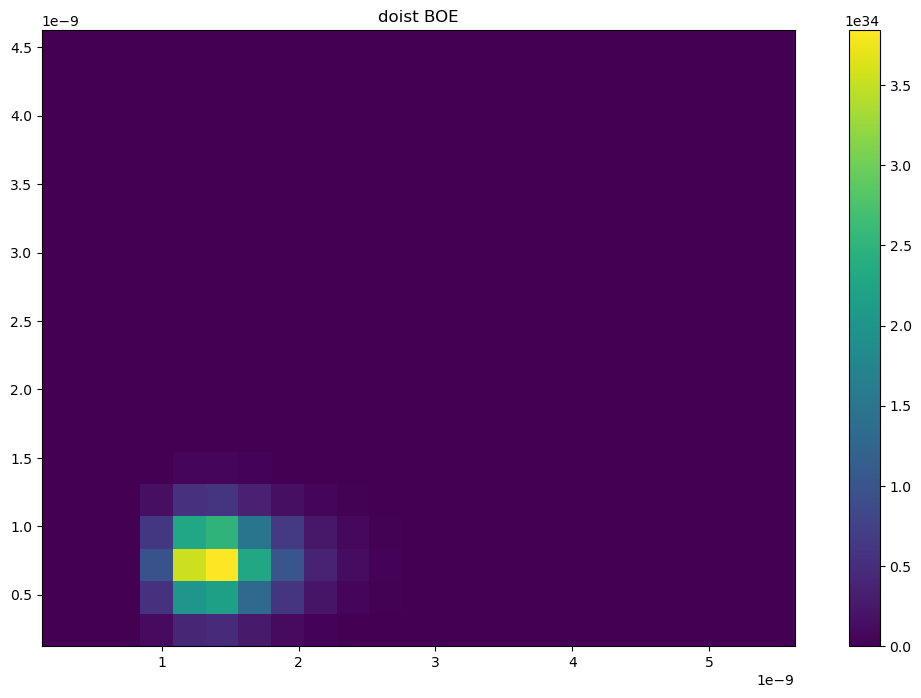

In [20]:
#interpolate to r values
fig=plt.figure(figsize=(14, 8))
ax11 = fig.add_subplot(1,1,1)
ax=ax11
im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
#im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower',norm=LogNorm(vmin=1e26, vmax=1e30))
fig.colorbar(im, ax=ax)
ax.set_title("doist BOE")



In [22]:
rezultat

 message: Optimization terminated successfully.
 success: True
     fun: 10.085678493222439
       x: [ 1.797e+00  2.816e+00  7.068e-01  4.051e+00]
     nit: 1
    nfev: 805

In [ ]:
#easily calculate pt/cu ratio.